In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Now let's create a function to apply this response to seismic data
def apply_galitzin_response(displacement_data, sampling_rate, T=21.8, T1=24.5, l=123.8, mu=0.2, A1=1040, k=38):
    """
    Apply Galitzin response to ground displacement data using the exact response function
    
    Parameters:
    - displacement_data: Ground displacement time series
    - sampling_rate: Sampling rate in Hz
    - T, T1, l, mu, A1, k: Galitzin parameters
    
    Returns:
    - Simulated Galitzin trace
    """
    # Calculate frequency response at Nyquist-appropriate resolution
    nyquist = sampling_rate / 2
    n_freqs = len(displacement_data) // 2 + 1
    freqs = np.linspace(0, nyquist, n_freqs)
    periods = np.ones_like(freqs)
    # Avoid division by zero at DC
    periods[1:] = 1.0 / freqs[1:]
    
    # Calculate Galitzin response using your formula
    u = periods / float(T)
    u1 = periods / T1
    fu = (2.*u/(1.+u**2))**2
    C1 = np.pi * l / (k*A1)
    xm = C1 * ym/periods * (1.+u**2) * (1.+u1**2) * np.sqrt(1.-fu*mu**2)
    amplitude = 1./xm
    
    # Calculate phase response
    phase = calculate_phase(u, u1, mu)
    phase_rad = phase * np.pi / 180
    
    # Create complex frequency response (amplitude and phase)
    response = amplitude * np.exp(1j * phase_rad)
    
    # Handle DC component (set to near zero)
    response[0] = 1e-10
    
    # Apply response in frequency domain
    data_fft = np.fft.rfft(displacement_data)
    data_fft_filtered = data_fft * response
    
    # Transform back to time domain
    galitzin_trace = np.fft.irfft(data_fft_filtered, n=len(displacement_data))
    
    return galitzin_trace

In [3]:
# Parameters
T = 21.8       # Pendulum natural period (seconds)
T1 = 24.5      # Galvanometer natural period (seconds)
l = 123.8      # Pendulum length (cm)
mu = 0.2       # Damping coefficient
A1 = 1040      # Static magnification
k = 38         # Coupling coefficient

# Create period array (log scale)
Tp = np.logspace(-1, 2, num=200)  # 0.1 to 100 seconds

# Calculate amplitude response using your formula
ym = 1.0
u = Tp / float(T)
u1 = Tp / T1
fu = (2.*u/(1.+u**2))**2
C1 = np.pi * l / (k*A1)
xm = C1 * ym/Tp * (1.+u**2) * (1.+u1**2) * np.sqrt(1.-fu*mu**2)
amplitude = 1./xm

# Calculate frequency and angular frequency for phase calculation
f = 1 / Tp
omega = 2 * np.pi * f

In [4]:
# Now let's calculate the phase response
# For Galitzin seismograph, phase shift depends on period ratios
# This is a simplified approximation based on theoretical considerations
def calculate_phase(u, u1, mu):
    """Calculate phase response based on period ratios"""
    # Base phase contribution from pendulum (90° at resonance, approaching 180° at high frequencies)
    pendulum_phase = np.arctan2(2*mu*u, 1-u**2)
    
    # Galvanometer contribution (similar behavior)
    galvanometer_phase = np.arctan2(2*0.5*u1, 1-u1**2)  # Assuming damping of 0.5 for galvanometer
    
    # Additional 90° for electromagnetic coupling
    coupling_phase = np.pi/2
    
    # Total phase is the sum, converted to degrees
    total_phase = (pendulum_phase + galvanometer_phase + coupling_phase) * 180/np.pi
    
    # Adjust phase to be within -180 to 180 range
    total_phase = np.mod(total_phase + 180, 360) - 180
    
    return total_phase

phase = calculate_phase(u, u1, mu)

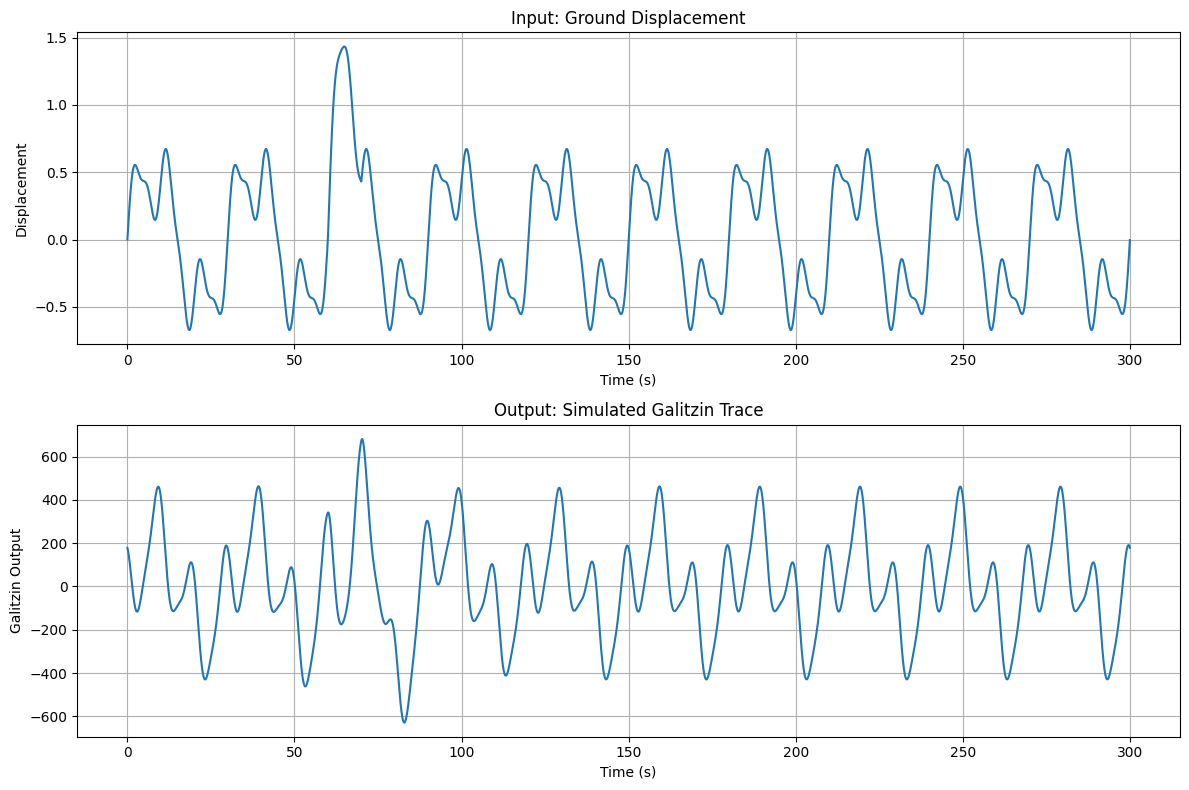

In [5]:
# Example application with crap synthetic data
sampling_rate = 100  # Hz
duration = 300  # seconds
t = np.arange(0, duration, 1/sampling_rate)

# Create synthetic displacement with various period components
displacement = np.zeros_like(t)

# Add a pulse signal (simulating P-wave)
pulse_idx = int(60 * sampling_rate)  # Pulse at 60s
pulse_width = int(10 * sampling_rate)  # 10s wide pulse
displacement[pulse_idx:pulse_idx+pulse_width] = np.sin(np.linspace(0, np.pi, pulse_width))

# Add some oscillations of different periods
displacement += 0.5 * np.sin(2*np.pi*t/30)  # 30s period
displacement += 0.3 * np.sin(2*np.pi*t/10)  # 10s period
displacement += 0.1 * np.sin(2*np.pi*t/5)   # 5s period

# Apply Galitzin response
galitzin_trace = apply_galitzin_response(displacement, sampling_rate)

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(t, displacement)
plt.title('Input: Ground Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.grid(True)

plt.subplot(212)
plt.plot(t, galitzin_trace)
plt.title('Output: Simulated Galitzin Trace')
plt.xlabel('Time (s)')
plt.ylabel('Galitzin Output')
plt.grid(True)

plt.tight_layout()
plt.show()